# Example 4: Eliptical slice sampling (ESS) for the prior-normalized posterior

In [19]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [20]:
# Import module. 
using Revise
using PriorNormalization

In [21]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant
using CairoMakie # for plots 
using Dates # to measure computational time 
using JLD2 # for saving and loading results 
using FFTW # for discrete cosine transform 
using FlexiMaps # for log-range 
using ImagePhantoms # for CT image 
using LinearAlgebra # to represent the identity matrix as "I" 
using MIRTjim: jim, prompt # for plotting image
using Printf # for specific output format 
using RadonKA # for Radon transform 
using Random # for generating random noise 
using Statistics  # for mean and quantile
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using OrdinaryDiffEq # for time integration
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Define the data model 

In [22]:
# Select the model i=1,2,3,4 for r=1,1/2,-1/2,-1
model_nr = 4

# Sampler parameters 
nr_chains = 4 # number of MCMC chains 
nr_samples_raw = 10^4 # Number of samples
thin = 10^1 # Thinning factor 
init = "prior" # Initialization option: "MAP", "prior"

"prior"

In [23]:
# Problem parameters 
n = 20 # number of pixes in each direction 
σ² = 1e-2 # noise variance  
Random.seed!(123) # Setting the random seed 
N = n^2

400

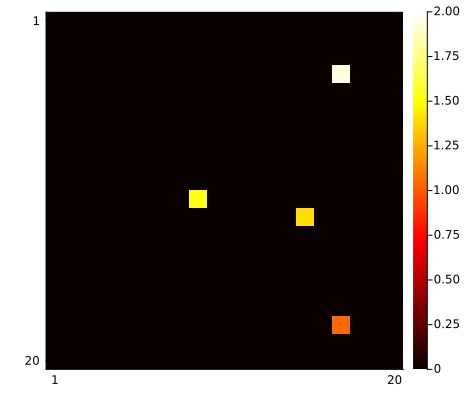

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_imageRef.pdf"

In [24]:
# Fill image with zeros 
image_ref = shepp_logan(n) 
image_ref .= 0

# Fill 5% of the entries with random numbers between 0 and 1 
nr_support = Int64(ceil( (n^2)*1/100 )) 
coord_support = rand(CartesianIndices(image_ref), nr_support)
values_support = rand(Float64, nr_support) .+ 1
image_ref[coord_support] = values_support

p = jim(image_ref, color=:hot, clim=(0,2), size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_n$(n)_imageRef.pdf"
)
#savefig(output_filename)

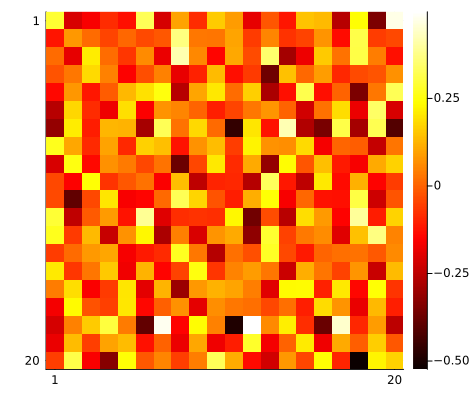

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_obsData.pdf"

In [25]:
image_obs = FFTW.dct(image_ref) + sqrt(σ²).*randn(size(image_ref))
p = jim(image_obs, color=:hot , size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_n$(n)_obsData.pdf"
)
#savefig(output_filename)

## Select the model: $r=-1$

In [26]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.00012308

In [27]:
# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = Interval(-5, 5)
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

Fun(Chebyshev(-5 .. 5), [4.1893, -6.76855, 3.39898, -0.818537, -0.068503, 0.0574292, 0.0200184, -0.00580982, -0.00554048, -0.000166345  …  -4.223e-10, -9.28847e-10, -2.06209e-10, 2.0424e-10, 1.39925e-10, -1.39843e-11, -4.54018e-11, -1.43472e-11, 1.03344e-11, 6.97238e-12])

## Load and transform the samples

In [28]:
# Select the file names for loading the MCMC results 
    
# Use MAP estimate 
if init=="MAP"
    filename_priorNormalized = joinpath("data", 
        "impulse_n$(n)_model$(model_nr)_mcmc_initMAP_ESS_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

elseif init=="prior"
    filename_priorNormalized = joinpath("data", 
        "impulse_n$(n)_model$(model_nr)_mcmc_initPrior_ESS_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end
    
@load filename_priorNormalized chn_priorNormalized wall_duration_priorNormalized

2-element Vector{Symbol}:
 :chn_priorNormalized
 :wall_duration_priorNormalized

In [29]:
# Initialize an array to store the transformed x vectors

# Array to store the sample values
nr_samples = size(chn_priorNormalized.value, 1)
chn_values = similar(chn_priorNormalized.value)  

# Change the parameter values 
# Transform each (τ,u) into (θ,x) samples 
Threads.@threads for j in 1:nr_chains
    for i in 1:nr_samples    
        θ = zeros(Float64,N)
        x = zeros(Float64,N)
        for n in 1:N 
            τ = chn_priorNormalized.value[i, 2*n-1, j]
            u = chn_priorNormalized.value[i, 2*n, j]
            x[n], θ[n] = priorNormalizing_KR_inv( u, τ; 
                r, β, ϑ, Φ=Γinvccdfcheb )
        end
        chn_values[i, 1:2:end-1, j] = θ
        chn_values[i, 2:2:end, j] = x
    end
end

# Change the parameter names 
# Extract the names of the parameters
parameter_names = names(chn_priorNormalized)
# Convert parameter names from symbols to strings
parameter_names_str = string.(parameter_names)
# Rename τ/u parameters to θ/x
signal_names_str = replace.(parameter_names_str, "τ" => "θ", "u" => "x")
# Convert parameter names back to symbols
signal_names = Symbol.(signal_names_str)

# Convert the transformed array back to a Chains object with updated parameter names
chn = Chains(chn_values, signal_names); 

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

## Load statistics

In [30]:
filename = joinpath(
        "data/impulse_n$(n)_model$(model_nr)_statistics_$(init)_ESS_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
@load filename x_mean x_std x_var x_upper_quantile theta_mean theta_std theta_var theta_upper_quantile

# Rename 
θ_mean = theta_mean
θ_std = theta_std
θ_var = theta_var
θ_upper_quantile = theta_upper_quantile

400-element Vector{Float64}:
 0.0013339838340808282
 0.0026137313647649806
 0.0017274836188242737
 0.002105781229239484
 0.0012570088779357798
 0.0016241950043182091
 0.0016372895384668285
 0.005820731097779394
 0.0017055638617224842
 0.00480364036449819
 ⋮
 0.001266414144058875
 0.004195960921302656
 0.0008786100023523801
 0.004959017218752593
 0.0037719732663455997
 0.0007474284826737673
 0.0028350426435246098
 0.0006842443601868599
 0.0009443417408400329

## Illustrate UQ for the original posterior

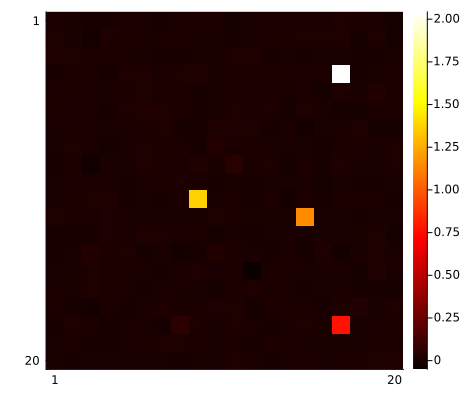

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_mean_ESS_priorNormalized.pdf"

In [31]:
# Plot mean for x 
image = reshape( x_mean, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of x", size = (475,400)) 
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_mean_ESS_priorNormalized.pdf"
)
#savefig(output_filename)

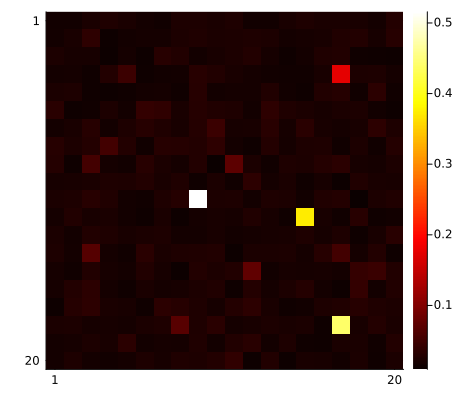

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_std_ESS_priorNormalized.pdf"

In [32]:
# Plot standard deviation for x 
image = reshape( x_std, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Std. of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_std_ESS_priorNormalized.pdf"
)
#savefig(output_filename)

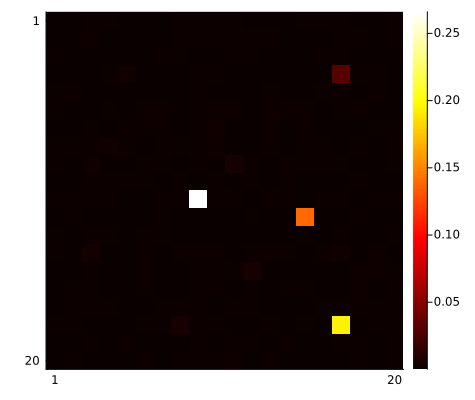

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_var_ESS_priorNormalized.pdf"

In [33]:
# Plot variance for x 
image = reshape( x_var, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Variance of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_var_ESS_priorNormalized.pdf"
)
#savefig(output_filename)

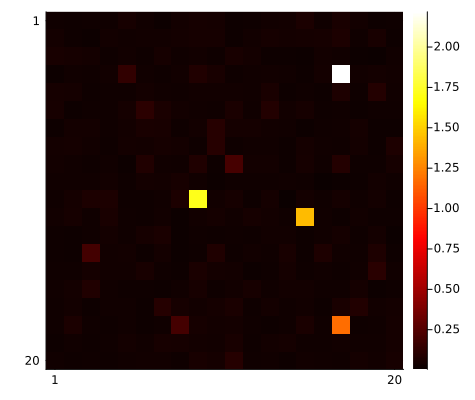

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_quantile_ESS_priorNormalized.pdf"

In [34]:
# Plot upper quantile for x 
image = reshape( x_upper_quantile, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="95% quantile of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_quantile_ESS_priorNormalized.pdf"
)
#savefig(output_filename)

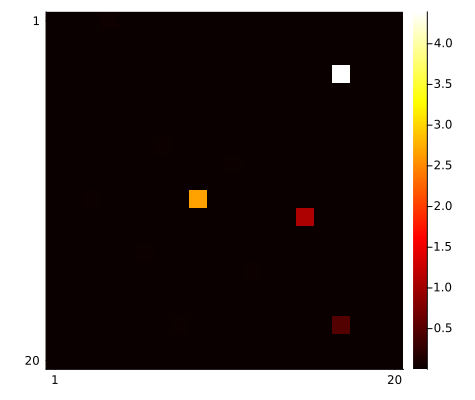

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_theta_mean_ESS_priorNormalized.pdf"

In [35]:
# Plot mean for θ 
image = reshape( θ_mean, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of θ", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_theta_mean_ESS_priorNormalized.pdf"
)
#savefig(output_filename)

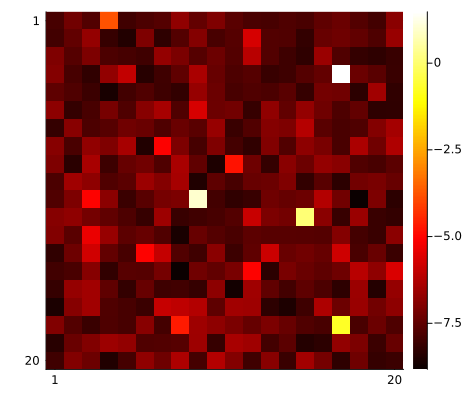

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_theta_logMean_ESS_priorNormalized.pdf"

In [36]:
# Plot mean for θ 
image = reshape( log.(θ_mean), n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of θ", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_theta_logMean_ESS_priorNormalized.pdf"
)
#savefig(output_filename)